In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/NLM-ChinaCXRSet-ReadMe.docx
/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0499_1.txt
/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0120_0.txt
/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0192_0.txt
/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0548_1.txt
/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0119_0.txt
/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0403_1.txt
/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/CHNCXR_0368_1.txt
/kaggle/input/pulmonary-chest-xray-abnormalitie

In [2]:

import cv2 as cv
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')
warnings.filterwarnings("ignore", category=DeprecationWarning)


2024-08-27 07:29:20.599148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 07:29:20.599249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 07:29:20.720582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:


cxr_images_folder = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'
cxr_masks_folder = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/'


cxr_paths = glob(os.path.join(cxr_images_folder, '*.png'))


image_paths = []
left_mask_paths = []
right_mask_paths = []

for c_path in cxr_paths:
    base_name = os.path.basename(c_path)
    mask_left_path = os.path.join(cxr_masks_folder, 'leftMask', base_name)
    mask_right_path = os.path.join(cxr_masks_folder, 'rightMask', base_name)
    
    image_paths.append(c_path)
    left_mask_paths.append(mask_left_path)
    right_mask_paths.append(mask_right_path)

print('Number of CXR images:', len(image_paths))
print('Sample CXR image path:', image_paths[0])
print('Number of left masks:', len(left_mask_paths))
print('Sample left mask path:', left_mask_paths[0])
print('Number of right masks:', len(right_mask_paths))
print('Sample right mask path:', right_mask_paths[0])

Number of CXR images: 138
Sample CXR image path: ../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0017_0.png
Number of left masks: 138
Sample left mask path: ../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0017_0.png
Number of right masks: 138
Sample right mask path: ../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0017_0.png


In [4]:
from skimage.io import imread
image=imread(cxr_paths[0])
plt.imshow(image)
print(image.shape)

(4020, 4892)


In [5]:
def preprocessing(path,l_path,r_path,shape,apply_clahe=False):
    'img preprocessing'
    src_image=tf.io.read_file(path)
    #src_image=tf.expand_dims(src_image,-1)
    src_image=tf.image.decode_image(src_image,channels=1)
    
    src_image.set_shape([None,None,1])
    
    'Resize the image'
    
    src_image=tf.image.resize(src_image,(shape,shape),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    src_image=tf.cast(src_image,tf.uint8)
    
    if apply_clahe:
        
        src_image_np = src_image.numpy()

            # Apply CLAHE
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        src_image_np = clahe.apply(src_image_np[:, :, 0])  # CLAHE works on single channel, remove channel dimension

            # Expand dims to add the channel back and convert back to tensor
        src_image = tf.expand_dims(src_image_np, axis=-1)

    
    src_image=tf.cast(src_image,tf.float32)/255
        
    src_image=tf.convert_to_tensor(src_image,dtype=tf.float32)
    
    'for mask'
    
    # Preprocess left mask
    mask_l = tf.io.read_file(l_path)
    mask_l = tf.image.decode_image(mask_l, channels=1)
    mask_l.set_shape([None,None,1])
    mask_l = tf.image.resize(mask_l, [shape, shape], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask_l = tf.cast(mask_l, tf.float32) / 255.0

    # Preprocess right mask
    mask_r = tf.io.read_file(r_path)
    mask_r = tf.image.decode_image(mask_r, channels=1)
    mask_r.set_shape([None,None,1])
    mask_r = tf.image.resize(mask_r, [shape, shape], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask_r = tf.cast(mask_r, tf.float32) / 255.0

    # Combine left and right masks
    mask = tf.reduce_max(tf.stack([mask_l, mask_r], axis=0), axis=0)
        
    return src_image,mask
    

In [6]:
img1,img2=preprocessing(image_paths[0],left_mask_paths[0],right_mask_paths[0],shape=256,apply_clahe=True)
img3,img4=preprocessing(image_paths[1],left_mask_paths[1],right_mask_paths[1],shape=256,apply_clahe=True)

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

Using ImageDataGenration with tf.data.DataSet

1- use from_tensor_slices on original list of path

2- map the preprocessing function on train and test

3-make a datagen object of the ImageDataGenration 

4- def a function for augumentation:
   - convert using img_to_array
   - use datagen.flow
   - use tf.convert_to_tensor

5- map the augumentation again

6-

(-0.5, 255.5, 255.5, -0.5)

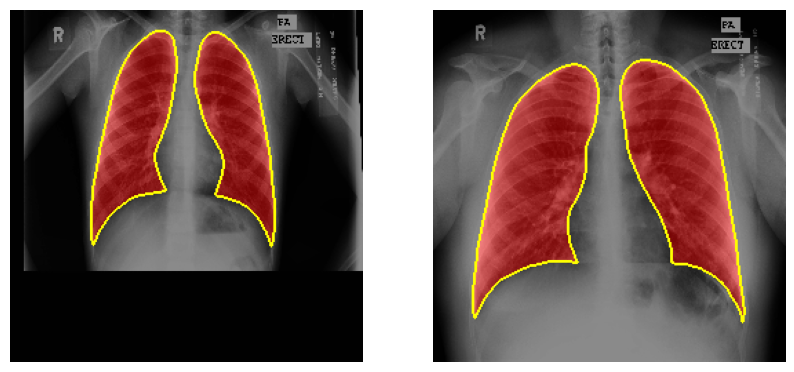

In [8]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb


def add_boundary(in_img,in_seg,alpha=0.45):
    
    src_img=in_img.numpy()
    mask=in_seg.numpy()
    # reshape the 
    # remove the single channel
    if src_img.shape[-1]==1:
        src_img=np.squeeze(src_img,axis=-1)
        
    
    
    ## convert the shape of input image to 3 channel
    
    src_img=np.stack([src_img]*3,axis=-1)
    
    
    # remove the channel dim of mask
    
    if mask.ndim==3 and mask.shape[-1]==1:
        mask=np.squeeze(mask,axis=-1)
        
    colored_mask=label2rgb(mask,image=src_img,alpha=alpha)
    
    
    over_lapped=mark_boundaries(colored_mask,mask,mode='thick')
    
    return over_lapped


    
over_lapped1=add_boundary(img1,img2)
over_lapped2=add_boundary(img3,img4)
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(over_lapped1)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(over_lapped2)
plt.axis('off')

    


In [9]:
def augment_image(src_image, mask):
    # Define data augmentation operations
    
    combined=tf.concat([src_image,mask],axis=-1)
    
    # random flips 
    combined=tf.image.random_flip_left_right(combined)
    combined=tf.image.random_flip_up_down(combined)
    
    # split the combined image
    src_image,mask=tf.split(combined,[tf.shape(src_image)[-1],tf.shape(mask)[-1]],axis=-1)
    
    src_image = tf.image.random_brightness(src_image, max_delta=0.1)
    src_image = tf.image.random_contrast(src_image, lower=0.9, upper=1.1)
    
    
   
    return src_image, mask

In [10]:
def create_dataset(image_paths,left_mask_paths,right_mask_paths,shape,test_size=0.1,valid_size=0.2,batch_size=4,shuffle=True):
    dataset=tf.data.Dataset.from_tensor_slices((image_paths,left_mask_paths,right_mask_paths))
    
    if shuffle:
        dataset=dataset.shuffle(buffer_size=len(image_paths))
        
    dataset = dataset.map(lambda src_image, mask_l, mask_r: preprocessing(src_image, mask_l, mask_r, shape),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    
    dataset_size=len(image_paths)
    test_size=int(test_size*dataset_size)
    valid_size=int(valid_size*dataset_size)
    train_size=dataset_size-test_size-valid_size
    
    train_dataset=dataset.take(train_size)
    val_test_dataset=dataset.skip(train_size)
    valid_dataset=val_test_dataset.take(valid_size)
    test_dataset=val_test_dataset.skip(valid_size)
    
    # apply the datagen to train dataset
    
    train_dataset=train_dataset.map(lambda src_image,mask : augment_image(src_image,mask),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # apply the batch function
    
    train_dataset=train_dataset.batch(batch_size)
    test_dataset=test_dataset.batch(batch_size)
    valid_dataset=valid_dataset.batch(batch_size)
    
    
    # prefetch the data for better performance
    
    train_dataset=train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    test_dataset=test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    valid_dataset=valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return  train_dataset,valid_dataset,test_dataset

In [11]:
train_dataset,valid_dataset,test_dataset=create_dataset(image_paths,left_mask_paths,right_mask_paths,shape=256,batch_size=4)

In [12]:
train_batch,train_mask=next(iter(train_dataset))
valid_batch,valid_mask=next(iter(valid_dataset))
test_batch,test_mask=next(iter(test_dataset))
print(f"train batch shape {train_batch.shape}")
print(f"valid batch shape {valid_batch.shape}")
print(f"test batch shape {test_batch.shape}")

train batch shape (4, 256, 256, 1)
valid batch shape (4, 256, 256, 1)
test batch shape (4, 256, 256, 1)


In [13]:


def show_samples_from_dataset(dataset, num_batches=1):
    # Iterate through the dataset
    for batch_num, (src_img, tar_img) in enumerate(dataset.take(num_batches)):
        # Rescale the images from [-1, 1] to [0, 1] for display
        
        # Plot the images
        plt.figure(figsize=(20,20))
        for i in range(len(src_img)):
            plt.subplot(len(src_img), 2, i * 2 + 1)
            plt.imshow(src_img[i].numpy().squeeze(), cmap='gray')
            #plt.title("Source Image")
            plt.axis("off")

            plt.subplot(len(src_img), 2, i * 2 + 2)
            plt.imshow(tar_img[i].numpy().squeeze(), cmap='gray')
            #plt.title("Target Image")
            plt.axis("off")
        
        plt.show()

# Example usage: Show images from one batch of the train_dataset
show_samples_from_dataset(train_dataset, num_batches=1)

In [14]:
## making a simple u-net architecture

def encoder(layer_in,n_filters,batchnorm=True):
    
    # adding random_noise 
    init=RandomNormal(stddev=0.02)
    
    ## adding downsampling layers
    x=Conv2D(n_filters,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    
    ## conditionaly adding batch_norm
    if batchnorm:
        x=BatchNormalization()(x,training=True)
        
    x=LeakyReLU(negative_slope=0.2)(x)
    
    return x
    
    
    
def decoder(layer_in,skip_in,n_filters,dropout=True):
    init=RandomNormal(stddev=0.02)
    
    ## adding upsampling layer
    
    x=Conv2DTranspose(n_filters,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    x=BatchNormalization()(x)
    
    # adding conditional dropout
    
    if dropout:
        x=Dropout(0.5)(x)
    ## merging with skip connection
    
    x=Concatenate()([x,skip_in])
    
    x=LeakyReLU(negative_slope=0.2)(x)
    
    return x
    
        
    
    
    

In [15]:
def U_NET():
    
    init=RandomNormal(stddev=0.02)
    
    in_layer=Input(shape=(size,size,1))
    
    
    ## downsampling layer
    
    e1=encoder(in_layer,64,batchnorm=False)
    e2=encoder(e1,128)
    e3=encoder(e2,256)
    e4=encoder(e3,512)
    e5=encoder(e4,512)
    e6=encoder(e5,512)
    e7=encoder(e6,512)
    
    ## bride layer
    
    b=Conv2D(512,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    
    ## upsampling
    
    u1=decoder(b,e7,512)
    u2=decoder(u1,e6,512)
    u3=decoder(u2,e5,512)
    u4=decoder(u3,e4,512,dropout=False)
    u5=decoder(u4,e3,256,dropout=False)
    u6=decoder(u5,e2,128,dropout=False)
    u7=decoder(u6,e1,64,dropout=False)
    
    output=Conv2DTranspose(1,(4,4),strides=(2,2),padding='same',kernel_initializer=init,activation='sigmoid')(u7)
    
    model=Model(in_layer,output)
   
    return model

In [16]:
size=256
u_net=U_NET()
u_net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 512) │  2,359,808 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 30,624,961 (116.82 MB)

 Trainable params: 30,615,105 (116.79 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [17]:
# define metrics related to image segmentation
# iou:-> intersection over union
# dice coeff
# dice_loss

In [18]:
loss=BinaryCrossentropy(from_logits=False)
opt=Adam(0.001,beta_1=0.9,beta_2=0.9999)
weight=2
smooth=1e-5

def dice_loss(mask,model_output):
    
    intersection=tf.reduce_sum(mask*model_output)
    union=tf.reduce_sum(mask)+tf.reduce_sum(model_output)
    dice=(2.0*intersection+smooth)/(union+smooth)
    return 1-(tf.reduce_mean(dice))

def iou(mask,model_output, epsilon=1e-15):
    mask = tf.reshape(mask, [-1])
    model_output = tf.reshape(model_output, [-1])

    intersection = tf.reduce_sum(mask * model_output)
    union = tf.reduce_sum(mask) + tf.reduce_sum(model_output) - intersection
    
    iou_value = (intersection + epsilon) / (union + epsilon)
    return iou_value

def model_loss(mask,model_output):
    loss1=loss(mask,model_output)
    Dice_loss=dice_loss(mask,model_output)
    iou_value=iou(mask,model_output)
    mean_error=tf.reduce_mean(tf.abs(mask-model_output))
    
    total_loss=loss1 + weight*Dice_loss
    
    return total_loss,Dice_loss,iou_value,mean_error

    
    

In [19]:
def validation(valid_dataset):
    total_loss_acc=0
    Dice_loss_acc=0
    iou_value_acc=0
    mean_error_acc=0
    num_batches=0
    
    for images,mask in valid_dataset:
        model_output=u_net(images,training=True)
        
        total_loss,Dice_loss,iou_value,mean_error=model_loss(mask,model_output)
        
        ## we need to average the loss for each epoch
        total_loss_acc +=total_loss
        Dice_loss_acc +=Dice_loss
        iou_value_acc += iou_value
        mean_error_acc += mean_error
        num_batches += 1
        
        
    total_loss_avg=total_loss_acc/num_batches
    dice_loss_avg=Dice_loss_acc/num_batches
    iou_loss_avg = iou_value_acc/num_batches
    mean_error_avg = mean_error_acc/num_batches
    
    return total_loss_avg,dice_loss_avg,iou_loss_avg,mean_error_avg
    

In [20]:
def training(input_image,mask,epochs):
    with tf.GradientTape() as unet_tape:
        model_output=u_net(input_image,training=True)
        
        total_loss,Dice_loss,iou_value,mean_error=model_loss(mask,model_output)
        
        model_grad=unet_tape.gradient(total_loss,u_net.trainable_variables)
        
        opt.apply_gradients(zip(model_grad,u_net.trainable_variables))
        
        return total_loss,Dice_loss,iou_value,mean_error
        

In [21]:
def fit(training_dataset,valid_dataset,epochs):
    
    total_loss_history = []
    dice_loss_history = []
    iou_history = []
    
    val_total_loss_history = []
    val_dice_loss_history = []
    val_iou_history = []
    
    
    for epoch in range(epochs):
        print(f"epoch :- {epoch+1}/{epochs}")
        
        epoch_total_loss = 0
        epoch_dice_loss = 0
        epoch_iou_value = 0
        step_count = 0
        
        for n,(src_image,mask) in training_dataset.enumerate():
            total_loss,Dice_loss,iou_value,mean_error=training(src_image,mask,epochs)
            
            # Accumulate values for averaging
            epoch_total_loss += total_loss.numpy()
            epoch_dice_loss += Dice_loss.numpy()
            epoch_iou_value += iou_value.numpy()
            step_count += 1
            
            # for plotting the metrics
            
            
            if n % 10==0:
                print(f"step :- {n}")
                print(f"  total_loss : {total_loss.numpy():.4f}")
                print(f"  dice_loss: {Dice_loss.numpy():.4f}")
                print(f"  iou_value: {iou_value.numpy():.4f}")
                print(f"  mean_error: {mean_error.numpy():.4f}")
            
        avg_total_loss = epoch_total_loss / step_count
        avg_dice_loss = epoch_dice_loss / step_count
        avg_iou_value = epoch_iou_value / step_count
        
         # Append to history lists
        total_loss_history.append(avg_total_loss)
        dice_loss_history.append(avg_dice_loss)
        iou_history.append(avg_iou_value)
        
        'Validation Steps'
        
        total_loss_avg,dice_loss_avg,iou_loss_avg,mean_error_avg=validation(valid_dataset)
        
        val_total_loss_history.append(total_loss_avg.numpy())
        val_dice_loss_history.append(dice_loss_avg.numpy())
        val_iou_history.append(iou_loss_avg.numpy())
        
        print(f"Validation Loss: {total_loss_avg.numpy():.4f}")
        print(f"Validation Dice Loss: {dice_loss_avg.numpy():.4f}")
        print(f"Validation IOU: {iou_loss_avg.numpy():.4f}")
        print(f"Validation Mean Error: {mean_error_avg.numpy():.4f}")
        
        
        
    # Plot the metrics
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(total_loss_history, label='Total Loss')
    plt.plot(val_total_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Total Loss over Epochs')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(dice_loss_history, label='Dice Loss')
    plt.plot(val_dice_loss_history, label='Validation Dice Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Loss')
    plt.title('Dice Loss over Epochs')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(iou_history, label='IOU Value')
    plt.plot(val_iou_history, label='Validation IOU')
    plt.xlabel('Epochs')
    plt.ylabel('IOU')
    plt.title('IOU over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
                
    u_net.save('/kaggle/working/u_net_segmentation_model_for_chest_x_ray.h5')
            

In [22]:
fit(train_dataset,valid_dataset,epochs=20)

epoch :- 1/20
step :- 0
  total_loss : 2.0006
  dice_loss: 0.6499
  iou_value: 0.2122
  mean_error: 0.5004
step :- 10
  total_loss : 1.1096
  dice_loss: 0.3808
  iou_value: 0.4484
  mean_error: 0.2614
step :- 20
  total_loss : 0.8630
  dice_loss: 0.3029
  iou_value: 0.5350
  mean_error: 0.1637
Validation Loss: 0.5758
Validation Dice Loss: 0.1972
Validation IOU: 0.6710
Validation Mean Error: 0.1114
epoch :- 2/20
step :- 0
  total_loss : 0.6802
  dice_loss: 0.2333
  iou_value: 0.6217
  mean_error: 0.1250
step :- 10
  total_loss : 0.7631
  dice_loss: 0.2505
  iou_value: 0.5994
  mean_error: 0.1192
step :- 20
  total_loss : 0.5397
  dice_loss: 0.1766
  iou_value: 0.6999
  mean_error: 0.0891
Validation Loss: 0.3943
Validation Dice Loss: 0.1289
Validation IOU: 0.7719
Validation Mean Error: 0.0667
epoch :- 3/20
step :- 0
  total_loss : 0.4690
  dice_loss: 0.1676
  iou_value: 0.7129
  mean_error: 0.0721
step :- 10
  total_loss : 0.3354
  dice_loss: 0.1075
  iou_value: 0.8059
  mean_error: 0.05

In [23]:
def prediction(model,test_dataset,num_images=5,alpha=0.45):
    
    plt.figure(figsize=(10,10))
  
    for i,(src_image,mask) in enumerate(test_dataset.take(num_images)):
        prediction=model(src_image,training=False)
        
        
        plt.figure(figsize=(15,15))

            # iterate over images in the batch

        for j in range(src_image.shape[0]):
            img=src_image[j]
            pred_mask=tf.sigmoid(prediction[j])
            pred_mask=tf.cast(pred_mask>0.5,dtype=tf.uint8)

            true_mask=mask[j]

            #pred_mask=tf.expand_dims(pred_mask,axis=-1)
            #true_mask=tf.expand_dims(true_mask,axis=-1)

            over_lapped=add_boundary(img,pred_mask,alpha=alpha)
            
            
            
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(over_lapped)
            plt.title("Predicted Mask with Boundaries")
            plt.axis('off')
            

            
            
        plt.tight_layout()
        plt.show()
        
            
    
    

<Figure size 1000x1000 with 0 Axes>

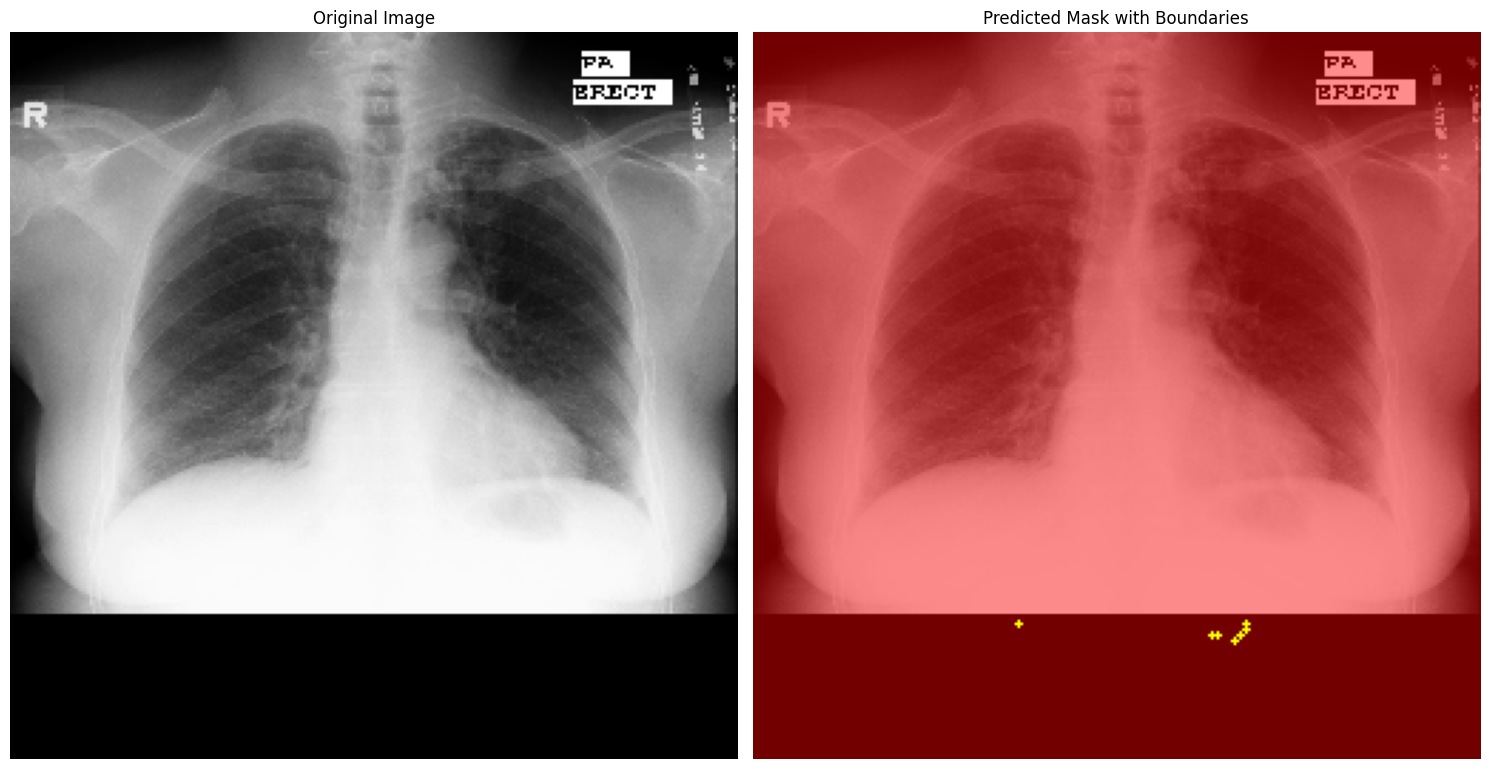

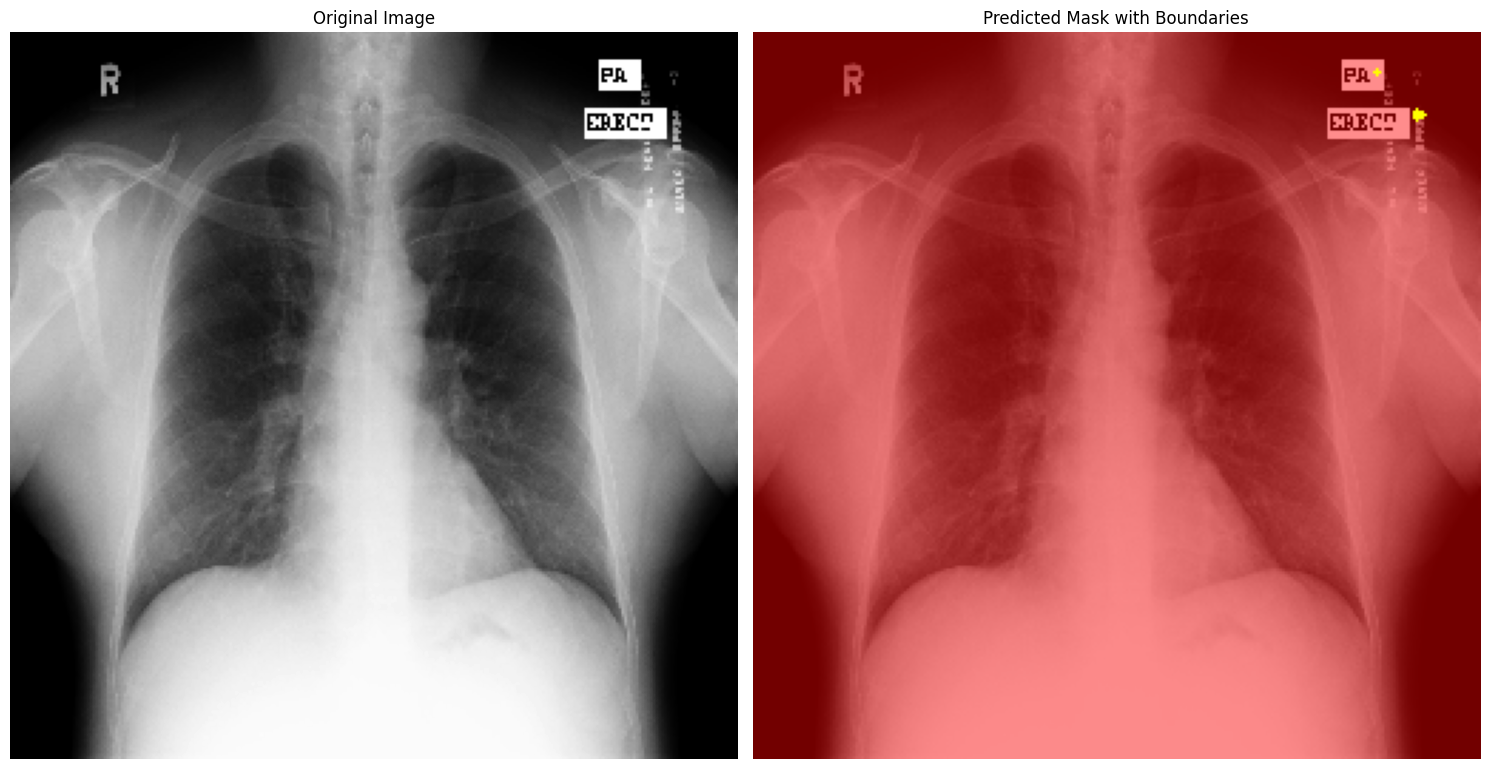

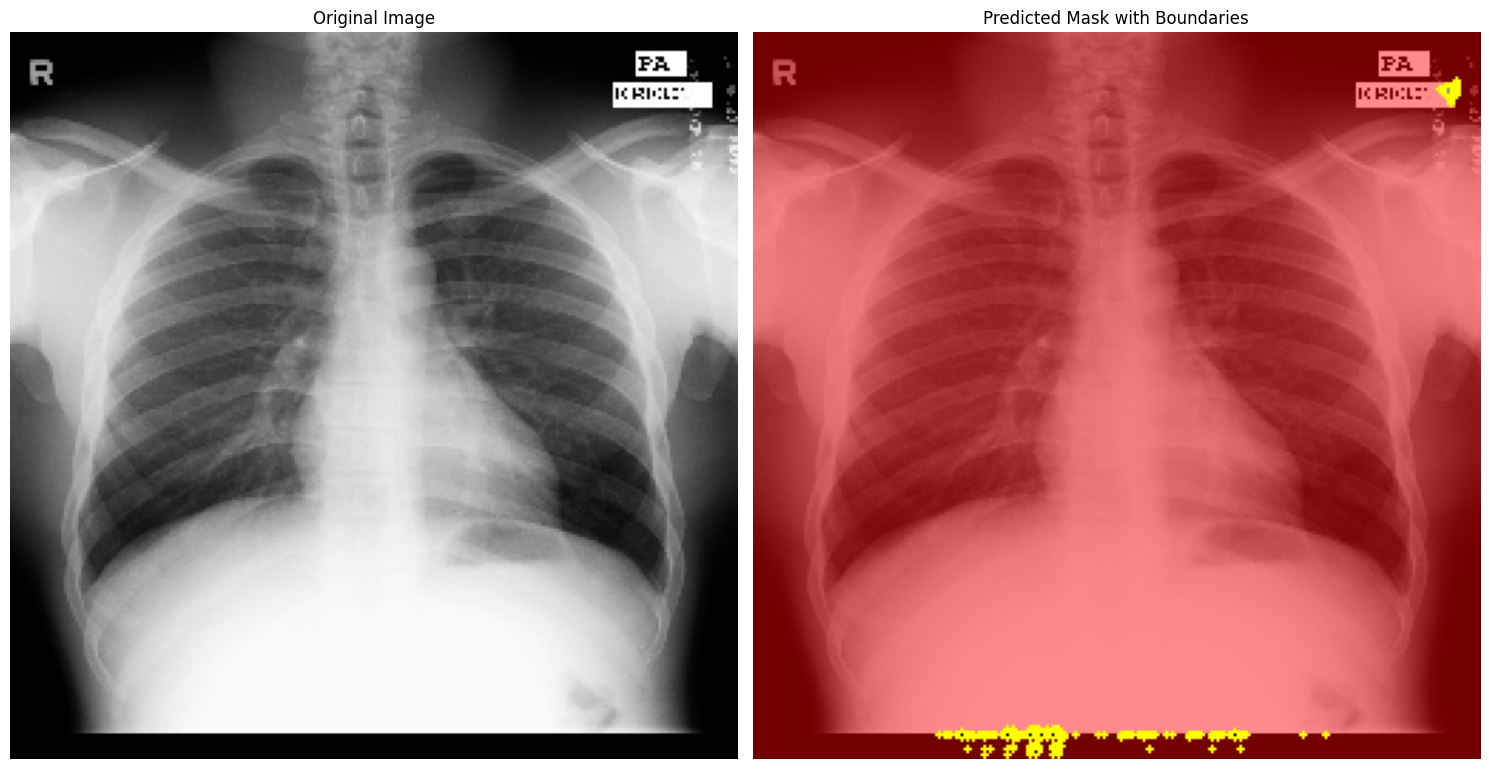

In [24]:
prediction(u_net,test_dataset,num_images=5,alpha=0.45)
